In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,plot_tree,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,roc_auc_score,mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,mean_squared_error
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [137]:
train_df=pd.read_csv("/content/big_mart_train.csv")

In [138]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [139]:
train_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [140]:
train_df_features = train_df.drop(columns=["Item_Outlet_Sales"])

# List of categorical columns
categorical_columns = ['Outlet_Size','Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Location_Type','Outlet_Type']

# List of numerical columns (excluding ID and target)
numerical_cols = ['Item_Weight']

# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le

# Fill numerical columns with median AFTER concatenation
for col in numerical_cols:
    median_value = train_df[col].median()
    train_df[col].fillna(median_value, inplace=True)

# Split the data back into train and test AFTER imputation
encoded_train_df = train_df.iloc[:len(train_df)].copy() # Use .copy() to avoid SettingWithCopyWarning


In [141]:
encoded_train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,1,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,2,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,1,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,2,0.000000,6,182.0950,0,1998,3,2,0,732.3800
4,1297,8.93,1,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [142]:
encoded_train_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [143]:
X = train_df.drop('Item_Outlet_Sales', axis=1)  # Features (all columns except target)
y = train_df['Item_Outlet_Sales']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

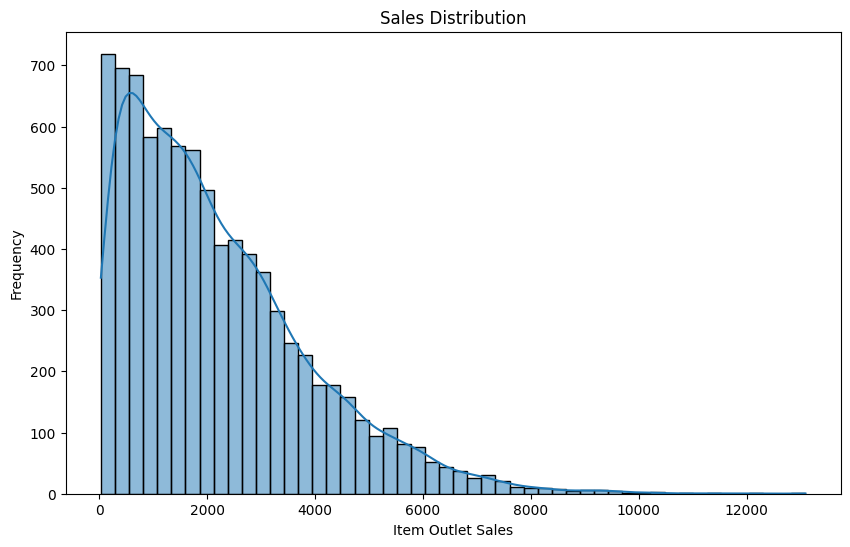

In [144]:
plt.figure(figsize=(10,6))
sns.histplot(encoded_train_df['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Item Outlet Sales')
plt.ylabel('Frequency')
plt.show()

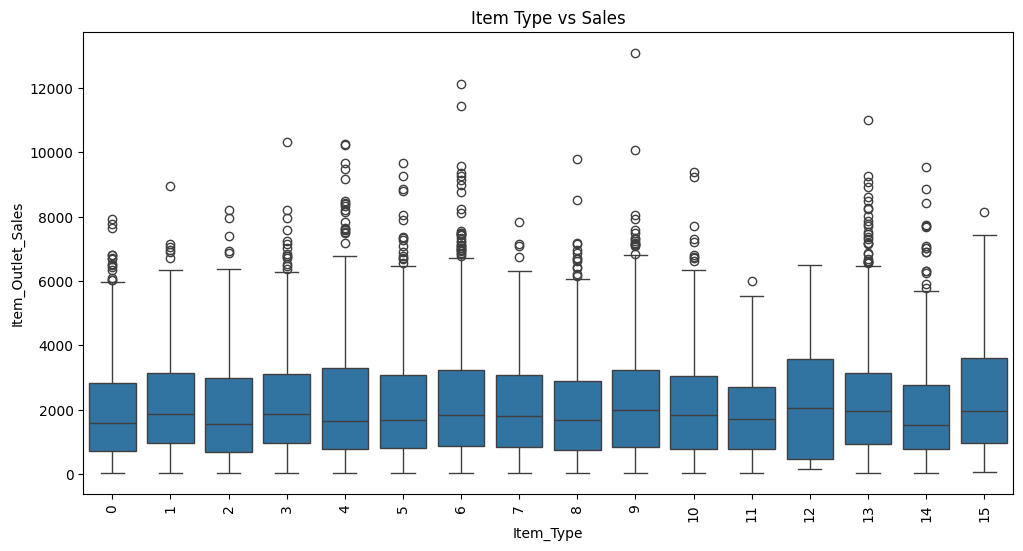

In [145]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=encoded_train_df)
plt.xticks(rotation=90)
plt.title('Item Type vs Sales')
plt.show()

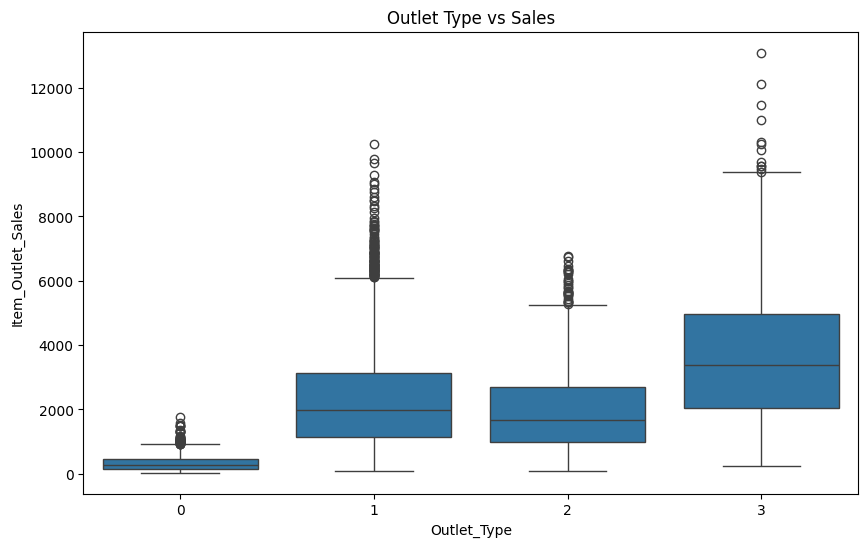

In [146]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=encoded_train_df)
plt.title('Outlet Type vs Sales')
plt.show()

Observations:
Highly Right-Skewed Distribution:
Most sales fall between 0 and 4000.
Long tail extending to over 12,000, indicating a few extreme outliers or very high-performing items.

Majority Clustered in Lower Range:
The peak (mode) is around 500–1000.

Median Sales:
All Item_Types (0 to 15) have similar median values, typically in the 1500–2500 range.
A few item types (e.g., 7, 10, 11) appear to have slightly higher median sales.
Spread (IQR and Whiskers):Categories like 7, 10, and 11 have larger spreads, indicating higher sales variability

Outlet Type 3 stands out with both the highest median sales and largest spread, making it the most successful outlet class.

In [147]:
#Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Evaluation (
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean absolute error: {mae}")
print(f"Mean Squared Error:{mse}")
print(f"R-squared (R²): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean absolute error: 855.6260187844358
Mean Squared Error:1303598.4887280997
R-squared (R²): 0.5203779082266368
Root Mean Squared Error (RMSE): 1141.752376274339


In [148]:
#Ridge
alpha_values=np.linspace(0.001, 100, 50)
scores = []
for a in alpha_values:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    scores.append([a, r2_score(y_test, y_pred)])
df_scores = pd.DataFrame(scores, columns=['alpha','score'])
print("Best alpha and score:\n",df_scores.sort_values('score', ascending=False).iloc[0])


Best alpha and score:
 alpha    10.204980
score     0.520948
Name: 5, dtype: float64


In [149]:
#Lasso
alpha_values=np.linspace(0.001, 100, 50)
scores = []
for a in alpha_values:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    scores.append([a, r2_score(y_test, y_pred)])
df_scores = pd.DataFrame(scores, columns=['alpha','score'])
print("Best alpha and score:\n",df_scores.sort_values('score', ascending=False).iloc[0])


Best alpha and score:
 alpha    2.041796
score    0.520891
Name: 1, dtype: float64


In [150]:
#ElasticNet
elastic = ElasticNet()
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
r2_score(y_test, y_pred)

alpha_values = [0.001, 0.01, 0.5, 1, 2.5, 5, 10, 20]
l1_r_values = [0.01, 0.2, 0.5, 0.7, 0.9]
scores = []
for a in alpha_values:
    for r in l1_r_values:
        elastic = ElasticNet(alpha=a, l1_ratio=r)
        elastic.fit(X_train, y_train)
        y_pred = elastic.predict(X_test)
        scores.append([a, r, r2_score(y_test, y_pred)])

df_scores = pd.DataFrame(scores, columns=['alpha','l1-ratio','score'])
print("Best alpha and score:\n",df_scores.sort_values('score', ascending=False).iloc[0])

df_scores.shape

Best alpha and score:
 alpha       0.01000
l1-ratio    0.90000
score       0.52091
Name: 9, dtype: float64


(40, 3)

### DTR

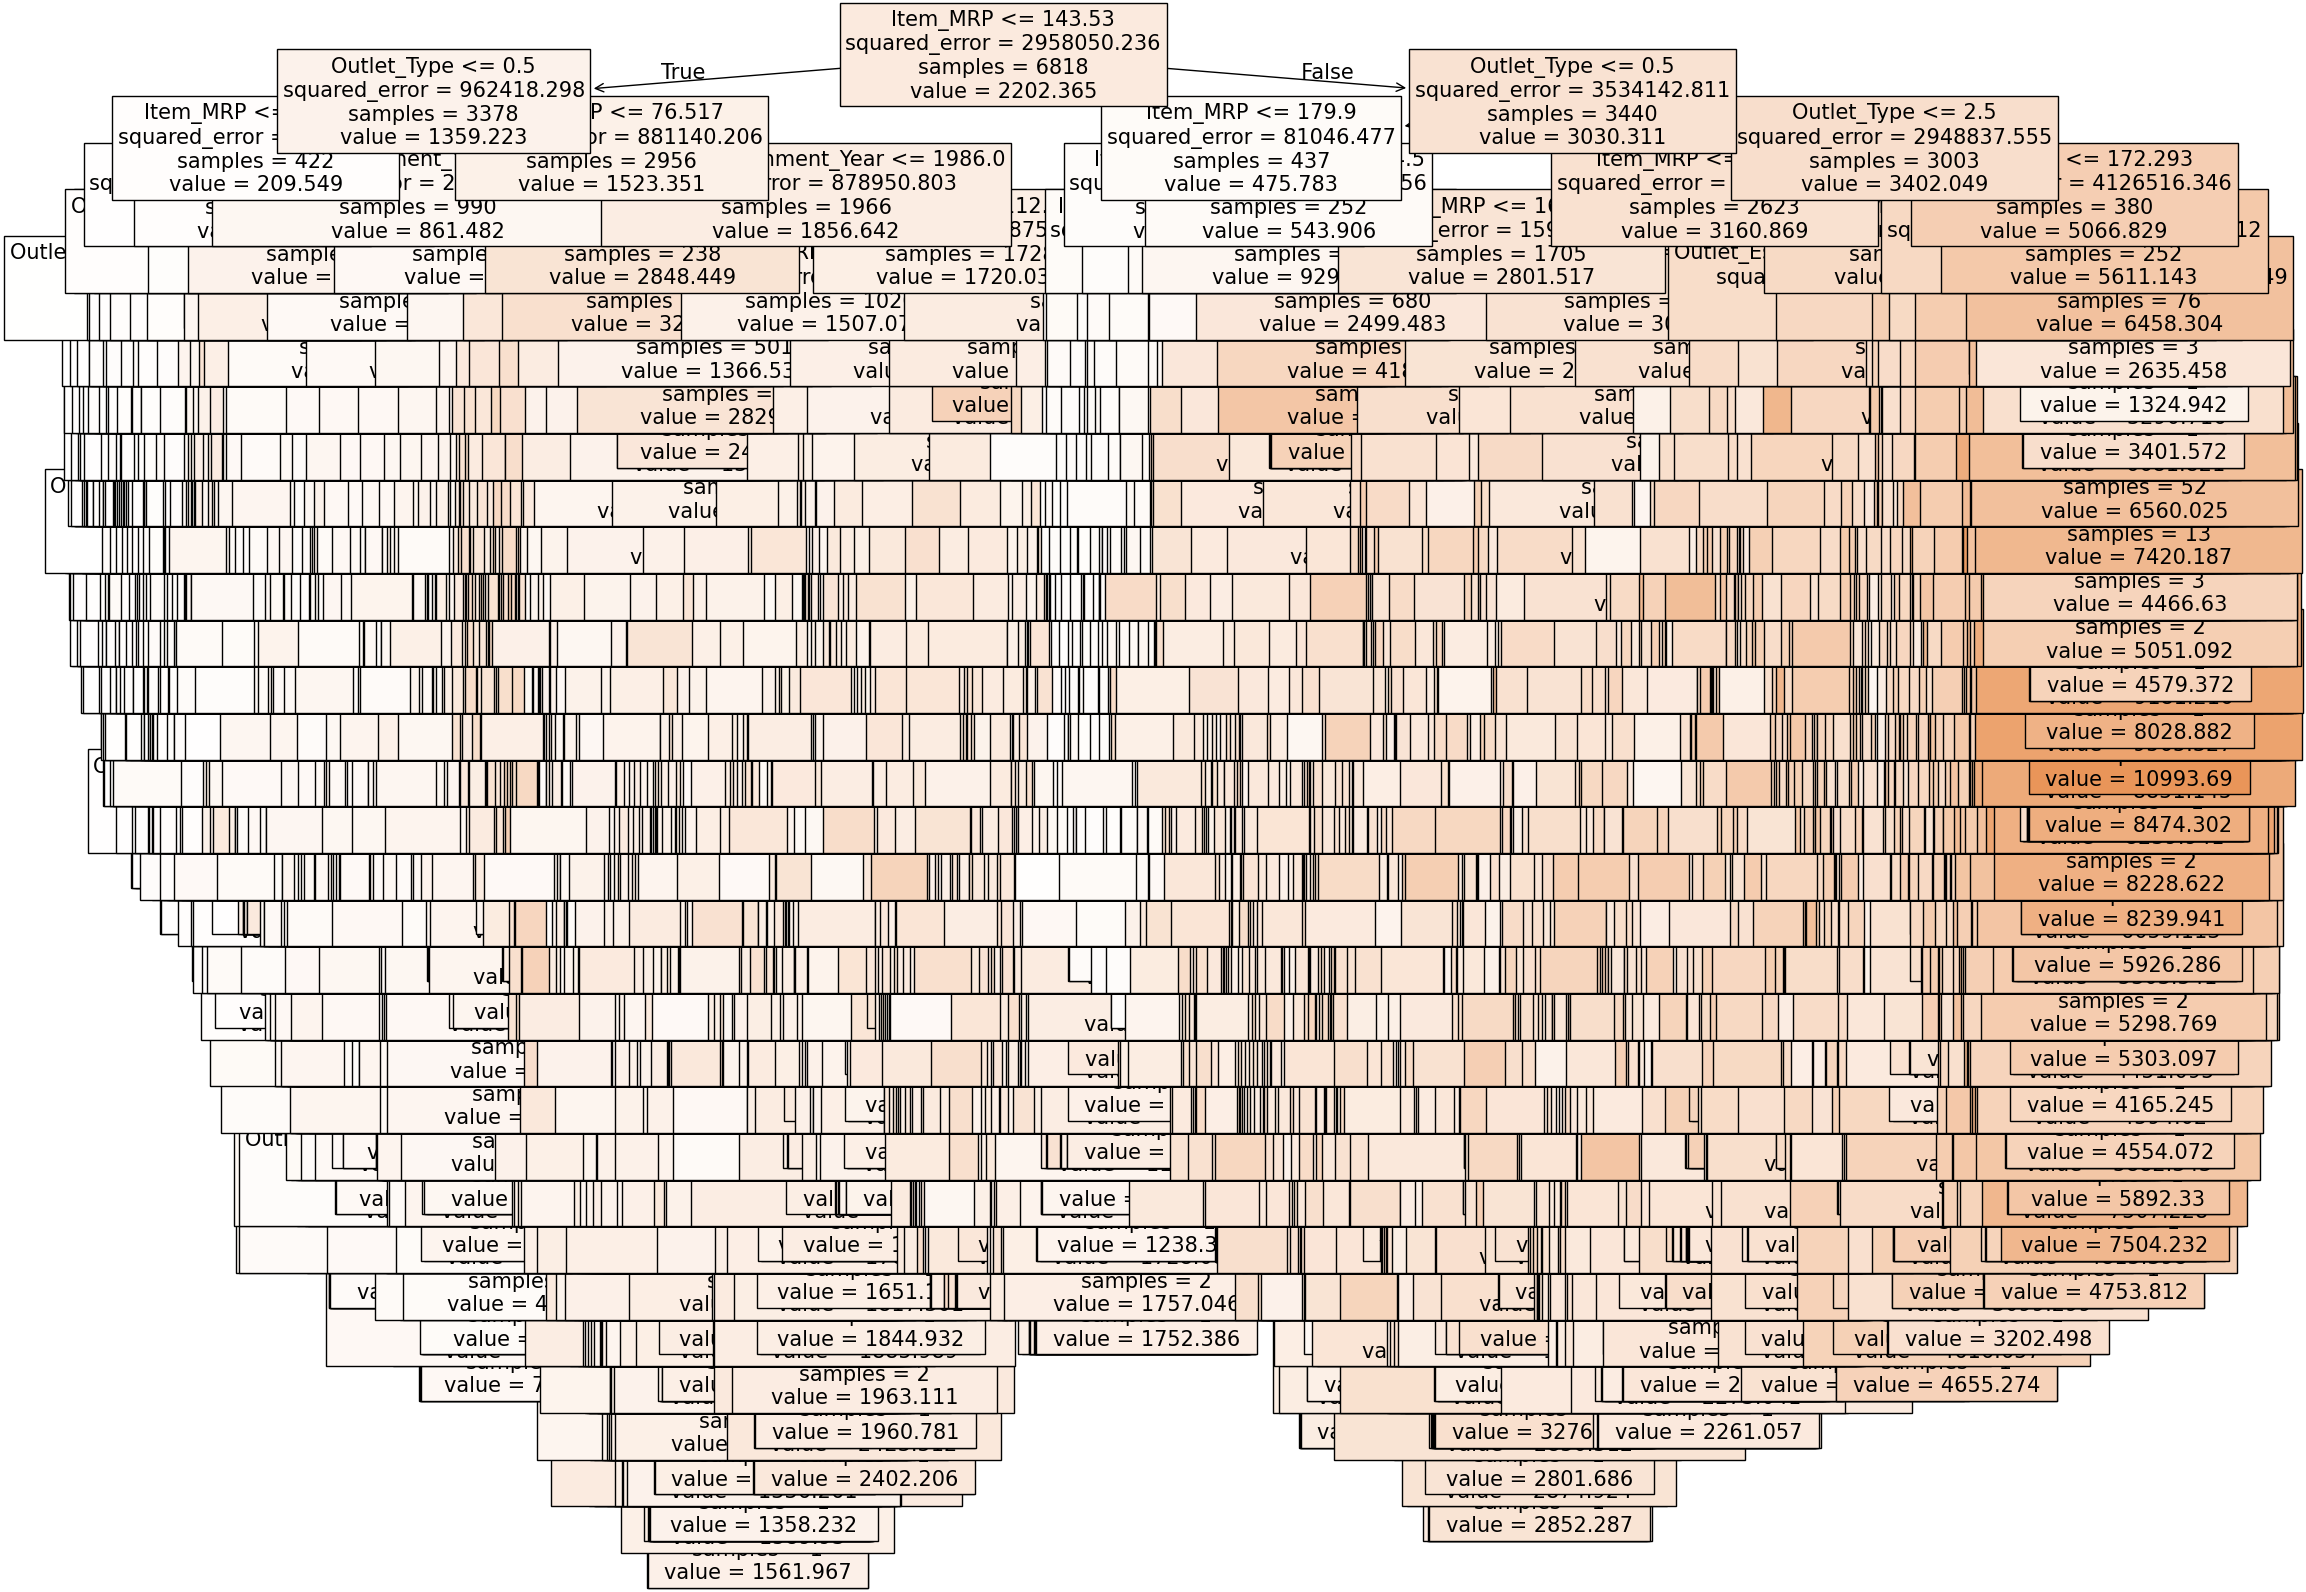

In [151]:
dtr = DecisionTreeRegressor(random_state=25)
dtr.fit(X_train, y_train)

plt.figure(figsize=(25,20))
plot_tree(dtr,feature_names=list(X.columns),  filled=True,fontsize=15)
plt.show()

In [152]:
y_pred = dtr.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

leaves = [1,5,10, 30, 50]
splits = [2,5,10, 30, 50]
depths = [None, 2,3]
scores = []
for d in depths:
    for s in splits:
        for l in leaves:
            dtr = DecisionTreeRegressor(random_state=25, min_samples_leaf=l, min_samples_split=s, max_depth=d)
            dtr.fit(X_train, y_train)
            y_pred = dtr.predict(X_test)
            scores.append([d,s,l,r2_score(y_test, y_pred)])
df_scores = pd.DataFrame(scores, columns=['Max Depth','Min Split','Min leaf','score'])
print("Best params and score:\n",df_scores.sort_values('score', ascending=False).iloc[0])

df_scores

0.1775993328772153
1047.451008445748
Best params and score:
 Max Depth          NaN
Min Split     2.000000
Min leaf     50.000000
score         0.596393
Name: 4, dtype: float64


,Max Depth,Min Split,Min leaf,score
0,NaN,2,1,0.177599
1,NaN,2,5,0.395253
2,NaN,2,10,0.499166
3,NaN,2,30,0.569535
4,NaN,2,50,0.596393
...,...,...,...,...
70,3.0,50,1,0.536438
71,3.0,50,5,0.536438
72,3.0,50,10,0.536438
73,3.0,50,30,0.536438


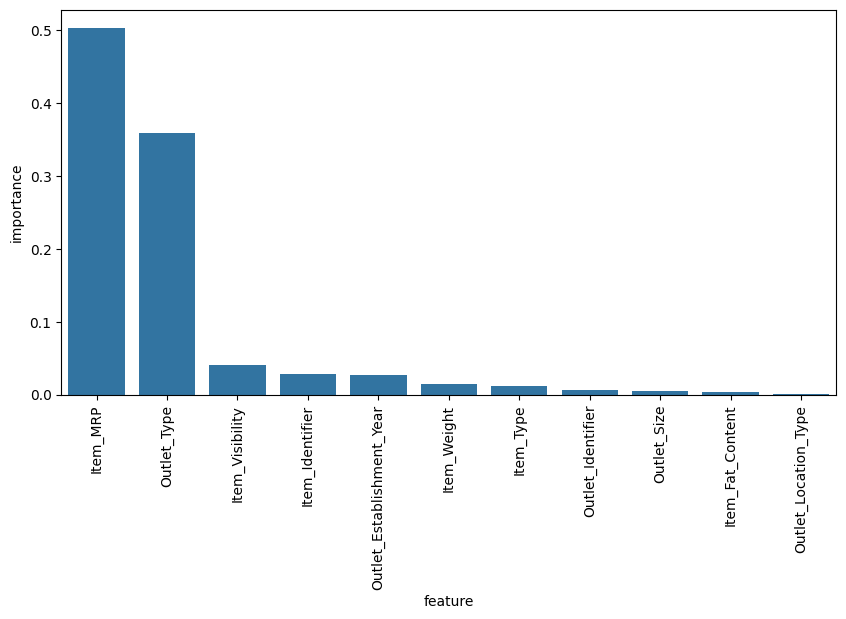

In [153]:
#Best Model

best_tree = DecisionTreeRegressor(random_state=25, min_samples_leaf=10, min_samples_split=2, max_depth=None)
best_tree.fit(X_train, y_train)

df_imp = pd.DataFrame({'feature': list(X.columns), 'importance': best_tree.feature_importances_})
df_imp = df_imp.sort_values('importance', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='feature', y='importance', data=df_imp)
plt.xticks(rotation=90)
plt.show()


In [154]:
#Random Forest
rf = RandomForestRegressor(random_state=25, n_estimators=25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

features = [3,4,5,6,7,8,9,10]
trees = [25, 50 , 100]
scores = []
for i in tqdm(range(len(features))):
    for t in trees:
        rf = RandomForestRegressor(random_state=25, n_estimators=t, max_features=features[i])
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores.append([features[i], t, r2_score(y_test, y_pred)])

df_scores = pd.DataFrame(scores, columns=['max_features','n_estimators','score'])
df_scores.sort_values('score',ascending=False)


100%|██████████| 8/8 [00:56<00:00,  7.12s/it]


,max_features,n_estimators,score
2,3,100,0.591346
1,3,50,0.588544
5,4,100,0.585421
0,3,25,0.581096
4,4,50,0.579398
8,5,100,0.576379
11,6,100,0.574739
3,4,25,0.574048
9,6,25,0.571691
14,7,100,0.570912


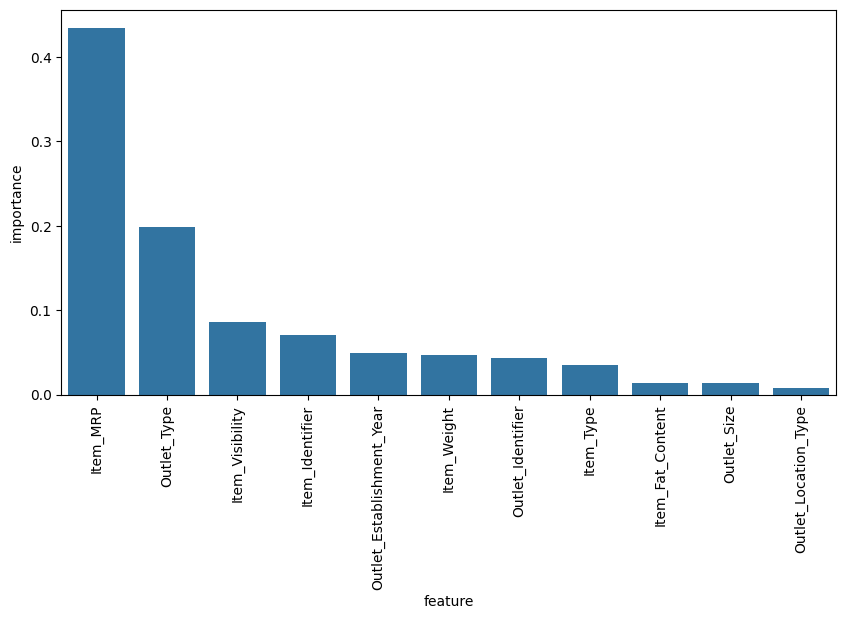

In [155]:
#### Feature Importance Plot

best_model = RandomForestRegressor(random_state=25, n_estimators=100, max_features=7)
best_model.fit(X, y)

df_imp = pd.DataFrame({'feature': list(X.columns), 'importance': best_model.feature_importances_})
df_imp = df_imp.sort_values('importance', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='feature', y='importance', data=df_imp)
plt.xticks(rotation=90)
plt.show()

In [156]:
#XGBRegressor
gbm = XGBRegressor(random_state=25)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
r2_score(y_test, y_pred)

0.5340503597127009

In [157]:
depths = [1,2,3,4, None]
l_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 0.8]
trees = [25, 50 ]
scores = []
for i in tqdm(range(len(l_rates))):
    for t in trees:
            for d in depths:
                gbm = XGBRegressor(random_state=25, learning_rate=l_rates[i],
                                                 n_estimators=t, max_depth=d)
                gbm.fit(X_train, y_train)
                y_pred = gbm.predict(X_test)
                scores.append([l_rates[i], t, d, r2_score(y_test, y_pred)])

df_scores = pd.DataFrame(scores, columns=['learning_rate','n_estimators','max_depth','score'])
df_scores.sort_values('score',ascending=False)


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


,learning_rate,n_estimators,max_depth,score
26,0.100,50,2.0,0.615504
32,0.200,25,3.0,0.615064
31,0.200,25,2.0,0.613733
27,0.100,50,3.0,0.612342
36,0.200,50,2.0,0.611728
23,0.100,25,4.0,0.610376
41,0.500,25,2.0,0.609834
33,0.200,25,4.0,0.609522
28,0.100,50,4.0,0.609392
37,0.200,50,3.0,0.606783


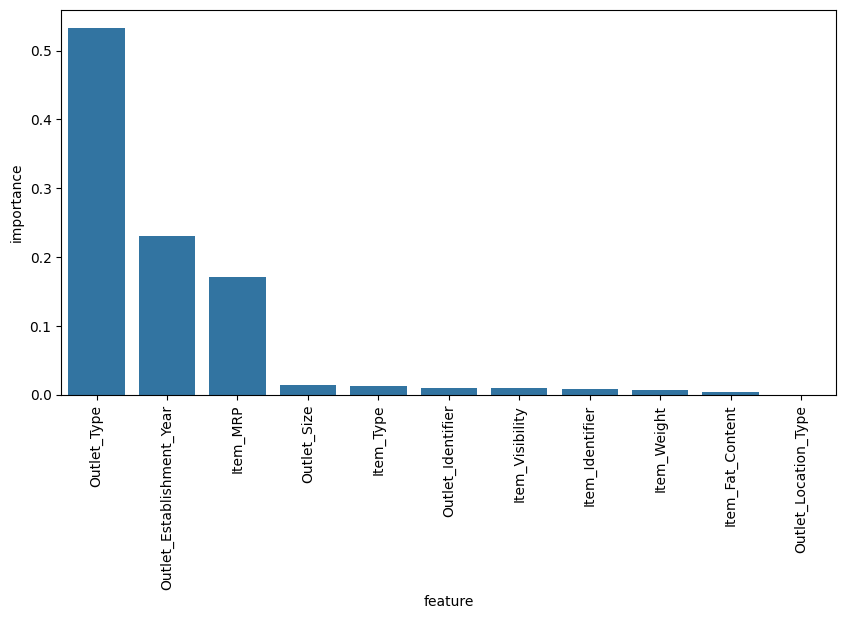

In [158]:
#### Feature Importance Plot

best_model = XGBRegressor(random_state=25,learning_rate=0.5,
                                        n_estimators=50, max_depth=3)
best_model.fit(X, y)

df_imp = pd.DataFrame({'feature': list(X.columns), 'importance': best_model.feature_importances_})
df_imp = df_imp.sort_values('importance', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='feature', y='importance', data=df_imp)
plt.xticks(rotation=90)
plt.show()

In [159]:
 #Model Performance Summary (R² Scores)

#  Model                      R2 Score
# Linear Regression         =  0.5199
# Ridge Regression          =  0.520541
# Lasso Regression          =  0.5204
# ElasticNet Regression     =  0.5205
# Decision Tree Regressor   =  0.58624
# Random Forest Regressor   =  0.592109
# XGBoost Regressor         = 0.615455

In [160]:
test_df=pd.read_csv("/content/big_mart_test.csv")

In [161]:
test_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,976
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,1606
Outlet_Location_Type,0


In [162]:
# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col].astype(str))
    label_encoders[col] = le

# Fill numerical columns with median AFTER concatenation
for col in numerical_cols:
    median_value = test_df[col].median()
    test_df[col].fillna(median_value, inplace=True)

encoded_test_df = test_df.iloc[:len(test_df)].copy()

In [163]:
encoded_test_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [183]:
scaler = MinMaxScaler().set_output(transform='pandas')
X_trn_scl = scaler.fit_transform(X_train)
X_tst_scl = scaler.transform(encoded_test_df.drop(columns=['Item_Outlet_Sales']))

In [184]:
XGB = XGBRegressor(random_state=25,learning_rate= 0.1, max_depth=2, n_estimators=75)
XGB.fit(X_trn_scl, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, random_state=25, ...)

In [185]:
XGB_testdata_pred = XGB.predict(X_tst_scl)

In [186]:
gbm = XGBRegressor(random_state=25)
gbm.fit(X_trn_scl, y_train)
y_pred = gbm.predict(X_tst_scl)

In [187]:
print("The outlet sales value for the new data is: ", XGB_testdata_pred)

The outlet sales value for the new data is:  [1627.3671 1425.7683  808.5737 ... 1912.3674 3546.7058 1283.0874]


In [188]:
len(XGB_testdata_pred)

5681

In [170]:
len(y_test)

1705

In [171]:
# Create the output DataFrame with the identifier columns and the predictions
output = encoded_test_df
output['Item_Outlet_Sales'] = XGB_testdata_pred

# Save the submission file
output.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!


In [172]:
Final_Testdata_submisson=pd.read_csv("/content/submission.csv")

In [173]:
Final_Testdata_submisson.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1103,20.750,1,0.007565,13,107.8622,9,1999,1,0,1,1627.3671
1,1067,8.300,4,0.038428,4,87.3198,2,2007,3,1,1,1425.7683
2,1406,14.600,1,0.099575,11,241.7538,0,1998,3,2,0,808.5737
3,809,7.315,1,0.015388,13,155.0340,2,2007,3,1,1,2510.5178
4,1184,12.500,2,0.118599,4,234.2300,5,1985,1,2,3,5996.4150


In [174]:
Final_Testdata_submisson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   int64  
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   int64  
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   int64  
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   int64  
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                5681 non-null   int64  
 9   Outlet_Location_Type       5681 non-null   int64  
 10  Outlet_Type                5681 non-null   int64  
 11  Item_Outlet_Sales          5681 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 532.7 KB


In [175]:
Final_Testdata_submisson.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


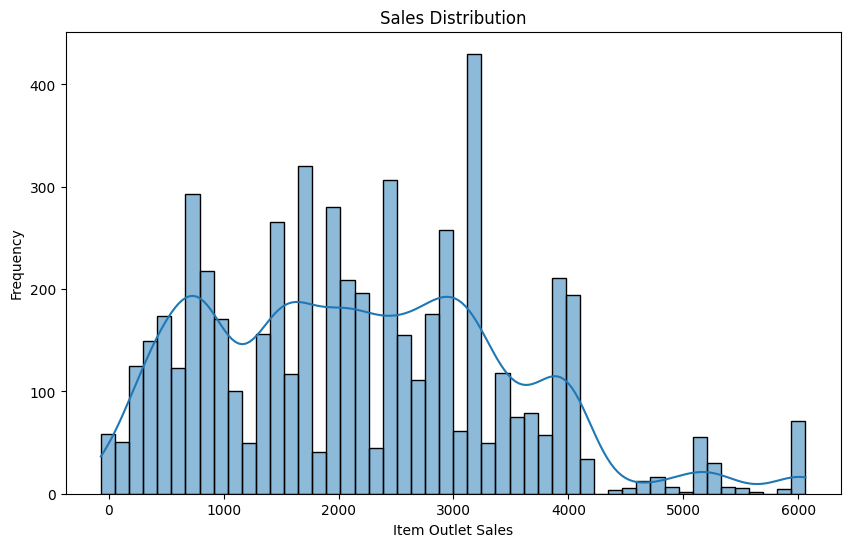

In [176]:
plt.figure(figsize=(10,6))
sns.histplot(Final_Testdata_submisson['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Item Outlet Sales')
plt.ylabel('Frequency')
plt.show()

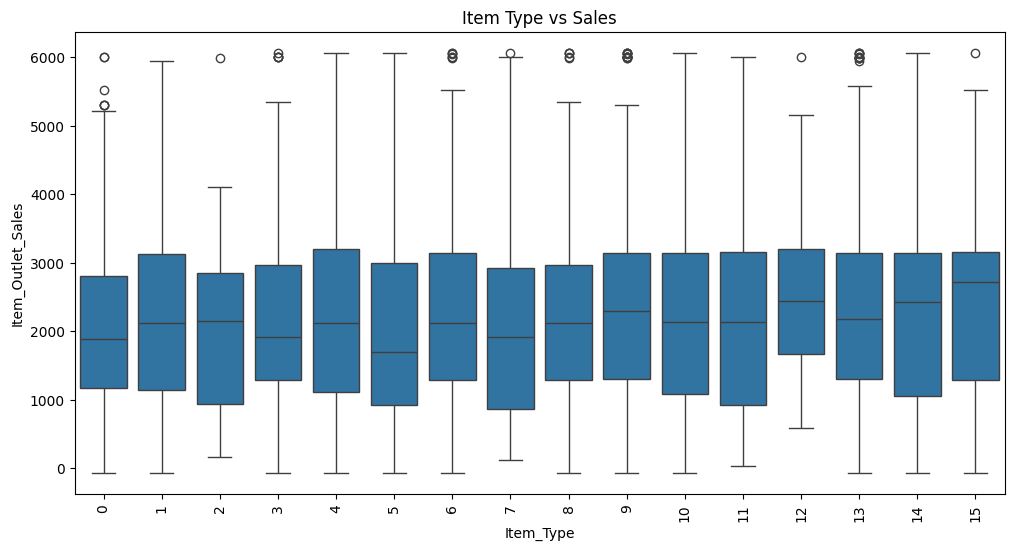

In [179]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=Final_Testdata_submisson)
plt.xticks(rotation=90)
plt.title('Item Type vs Sales')
plt.show()

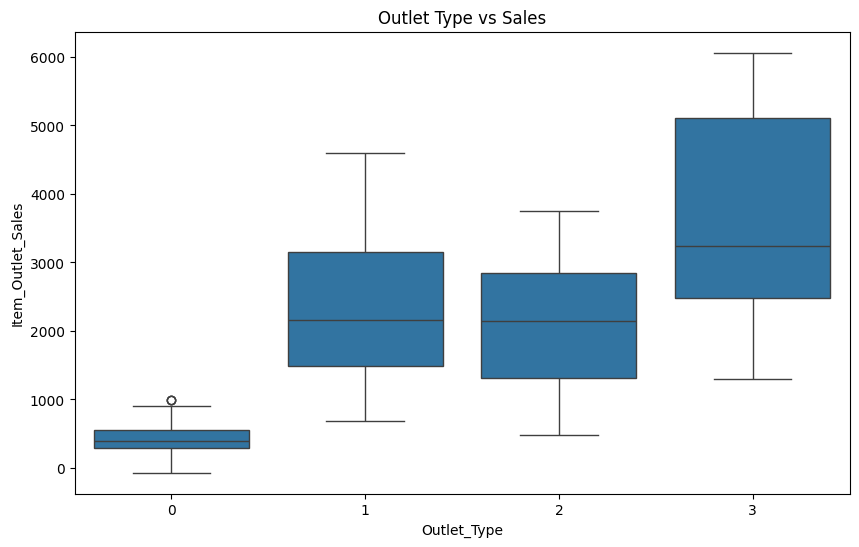

In [178]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=Final_Testdata_submisson)
plt.title('Outlet Type vs Sales')
plt.show()

###Obeservations:
Multimodal Distribution multiple peaks, suggesting the presence of distinct customer or product groups contributing to sales at different levels.

Right-Skewed Tail While most sales cluster between 500 and 4000, there's a long tail extending to 6000+, indicating some high-performing products or promotions.

Type 3	Highest median and max values. This outlet type (maybe Supermarket Type3) performs the best in terms of sales.

Outliers are visible across almost all types, especially near the upper range (~6000+ sales), suggesting certain products occasionally sell much more than average.